In [202]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats #for chi-squared
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

In [203]:
#Import data as pd dataframe; make sure company_id and employee_id are imported as int
employee = pd.read_csv("/home/lauren/Downloads/employee_retention_data.csv", dtype={"company_id": int, "employee_id": int})

# Question #1 : Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.

In [204]:
#Inspect data
employee.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000.0,2014-10-13,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [205]:
#Inspect dates to see if strings
employee["join_date"].dtype #string because it's an object ('0') in pandas

dtype('O')

In [206]:
#Convert pandas string of dates to datetime 
employee['join_date'] = pd.to_datetime(employee['join_date'], format="%Y-%m-%d")
employee['quit_date'] = pd.to_datetime(employee['quit_date'], format="%Y-%m-%d")

#See if converted correctly
s = employee['join_date']
print s[:5]

t= employee['quit_date']
print t[:5]

0   2014-03-24
1   2013-04-29
2   2014-10-13
3   2012-05-14
4   2011-10-17
Name: join_date, dtype: datetime64[ns]
0   2015-10-30
1   2014-04-04
2          NaT
3   2013-06-07
4   2014-08-22
Name: quit_date, dtype: datetime64[ns]


In [207]:
#See number of missing quit_date
employee.isnull().sum() #11,192 missing quit date (=> didn't quit yet or dropped out)

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [208]:
#See total N
employee.shape #N=24,702

(24702, 7)

In [209]:
#Create date range beginning on 2011-01-23 to 2015-12-13
date1 = '2011-01-23'
date2 = '2015-12-13'
#Create data ranges using "bdate" --> business day
mydates = pd.bdate_range(date1, date2)
mydates[1:10]

DatetimeIndex(['2011-01-25', '2011-01-26', '2011-01-27', '2011-01-28',
               '2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04'],
              dtype='datetime64[ns]', freq='B')

In [210]:
#Make sure dates are in datetime for manipulation
mydates = pd.to_datetime(mydates, format="%Y-%m-%d")
print mydates[1:10]

DatetimeIndex(['2011-01-25', '2011-01-26', '2011-01-27', '2011-01-28',
               '2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04'],
              dtype='datetime64[ns]', freq='B')


In [211]:
#Create dataframe from groupby output
#Count number of people who joined (i.e., # of repeated dates for each join date, by company_id)
joinct = pd.DataFrame(employee.groupby(["company_id", "join_date"]).size().reset_index(name="join_count"))
joinct.head()

,company_id,join_date,join_count
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [212]:
#To be safe, convert join_date to datetime
joinct['join_date'] = pd.to_datetime(joinct['join_date'], format="%Y-%m-%d")

#See if converted correctly
s = joinct['join_date']
print s[:5]

0   2011-01-24
1   2011-01-25
2   2011-01-26
3   2011-01-31
4   2011-02-01
Name: join_date, dtype: datetime64[ns]


In [213]:
#Sort join dataset by company_id and join_date
joinct_2 = joinct.sort(['company_id','join_date'])
joinct_2.head()

/home/lauren/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,company_id,join_date,join_count
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [214]:
#Sample index to see if correctly constructed
joinct_2[joinct_2['company_id'] == 2][1:10] #indexing by column

,company_id,join_date,join_count
845,2,2011-01-25,2
846,2,2011-01-31,12
847,2,2011-02-01,2
848,2,2011-02-02,2
849,2,2011-02-03,1
850,2,2011-02-07,19
851,2,2011-02-08,2
852,2,2011-02-09,1
853,2,2011-02-14,14


In [215]:
#Rename column names for merging with quit dataframe
joinct_2.columns = ['company_id', 'date', 'join_count']
joinct_2.head()

,company_id,date,join_count
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [216]:
#Create quit dataframe the same way as you created join dataframe
quitct = pd.DataFrame(employee.groupby(['company_id', 'quit_date']).size().reset_index(name="quit_count"))
quitct.head()

,company_id,quit_date,quit_count
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [217]:
#Convert dates to datatime for manipulation
quitct['quit_date'] = pd.to_datetime(quitct['quit_date'], format="%Y-%m-%d")

#See if converted correctly
s2 = quitct['quit_date']
print s2[:5]

0   2011-10-21
1   2011-11-11
2   2011-11-22
3   2011-11-25
4   2011-12-09
Name: quit_date, dtype: datetime64[ns]


In [218]:
#Sort quit dataframe by company_id and quit_date
quitct_2 = quitct.sort(['company_id','quit_date'])
quitct_2.head()

/home/lauren/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,company_id,quit_date,quit_count
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [219]:
#Rename columns so can merge with join df by company_id and date
quitct_2.columns = ['company_id', 'date', 'quit_count']
quitct_2.head()

,company_id,date,quit_count
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [220]:
#Merge join and quit dfs by company_id and date --> choose outer because we want to capture all dates
merged =  pd.merge(joinct_2, quitct_2, on=['company_id', 'date'], how = 'outer')
merged = merged.sort(['company_id', 'date'])
#merged[150:200]
merged[1:10]

/home/lauren/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,company_id,date,join_count,quit_count
1,1.0,2011-01-25,2.0,NaN
2,1.0,2011-01-26,2.0,NaN
3,1.0,2011-01-31,30.0,NaN
4,1.0,2011-02-01,7.0,NaN
5,1.0,2011-02-02,1.0,NaN
6,1.0,2011-02-07,32.0,NaN
7,1.0,2011-02-08,3.0,NaN
8,1.0,2011-02-09,2.0,NaN
9,1.0,2011-02-14,25.0,NaN


In [221]:
#Will be a surplus of join dates because not everyone quit by the end of study period --> thus, need to fill in missing with 0
merged2 = merged.fillna(0)
merged2[:10]

,company_id,date,join_count,quit_count
0,1.0,2011-01-24,25.0,0.0
1,1.0,2011-01-25,2.0,0.0
2,1.0,2011-01-26,2.0,0.0
3,1.0,2011-01-31,30.0,0.0
4,1.0,2011-02-01,7.0,0.0
5,1.0,2011-02-02,1.0,0.0
6,1.0,2011-02-07,32.0,0.0
7,1.0,2011-02-08,3.0,0.0
8,1.0,2011-02-09,2.0,0.0
9,1.0,2011-02-14,25.0,0.0


In [222]:
#Create 'net' variable = on a particular date within a particular company, what was the net number of people?
#Join - Quit = Net
merged2['net'] = merged2['join_count'] - merged2['quit_count']
merged2 = merged2.sort(['company_id', 'date'])
merged2.head()
#See if merged worked
print merged2[merged2['company_id']==6][1:10]

      company_id       date  join_count  quit_count  net
3098         6.0 2011-01-31         7.0         0.0  7.0
3099         6.0 2011-02-01         1.0         0.0  1.0
3100         6.0 2011-02-07         4.0         0.0  4.0
3101         6.0 2011-02-14         6.0         0.0  6.0
3102         6.0 2011-02-15         1.0         0.0  1.0
3103         6.0 2011-02-22         3.0         0.0  3.0
3104         6.0 2011-02-28         6.0         0.0  6.0
3105         6.0 2011-03-01         2.0         0.0  2.0
3106         6.0 2011-03-02         1.0         0.0  1.0


/home/lauren/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [223]:
#Create a list of the dates in the desired date range as well as the dates for joining that are in our dataset
mydateslist = mydates2['date'].tolist()
joinlist =employee['join_date'].tolist()

#A way to count how many people joined by date
#Can rerun this for each company_id dataset then create cumulative 
results={} #create a dictionary
#count = 0
for dates in mydateslist:
    if dates in joinlist:
        #count += joinlist.count(dates)
        results[dates] = joinlist.count(dates) #counts number of times date is in join list = #joined on that date
#results

In [224]:
#For next loop need to make sure date range of interest is in a dataframe so can combine with merged dataframe (#join and quit)
mydates2 = pd.DataFrame(mydates)
mydates2[1:10]
mydates2.columns = ['date']

### The code below ouputs large dataframe that includes the cumulative headcounts per company for all the business days between from 2011/01/24 to 2015/12/13. 

In [225]:
#The main loop for answering the question #1:
#Find the headcount for each date in date range () by company

headcountdata = pd.DataFrame() #create an empty dataframe that the loop will add to

#def headcount(i):
for i in range(1,13):
    df = merged2[merged2['company_id'] == i]
    result = pd.merge(df, mydates2, how='outer')
    result['company_id'] = result.company_id.fillna(i)
    result.update(result[['join_count','quit_count','net']].fillna(0))
    result= result.sort(['company_id','date'])
    result['head_count'] = result['net'].cumsum()
    headcountdata = headcountdata.append(result, ignore_index = True) #add to datafrane

headcountdata[['company_id','date','head_count']][0:10] #subset necessary variables 

/home/lauren/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,company_id,date,head_count
0,1.0,2011-01-24,25.0
1,1.0,2011-01-25,27.0
2,1.0,2011-01-26,29.0
3,1.0,2011-01-27,29.0
4,1.0,2011-01-28,29.0
5,1.0,2011-01-31,59.0
6,1.0,2011-02-01,66.0
7,1.0,2011-02-02,67.0
8,1.0,2011-02-03,67.0
9,1.0,2011-02-04,67.0


# Question 2: What are the main factors that drive employee churn?

In [226]:
#Create time-to-event variable called time' and variable for whether person quit (1 = yes, 0 = no)

#For those without a quit_date, create quit date= 2015/12/13 but event = 0
employee['join_date'] = pd.to_datetime(employee['join_date'], format="%Y-%m-%d")
employee['quit_date'] = pd.to_datetime(employee['quit_date'], format="%Y-%m-%d")

#Create end date for missing quit_dates
d = datetime.strptime('2015-12-13', "%Y-%m-%d")
d_end = pd.to_datetime('2015-12-13', format = "%Y-%m-%d")
print d_end
print employee.head()#check out original dataset to see where quit_date missing so can verify in next step

2015-12-13 00:00:00
   employee_id  company_id              dept  seniority    salary  join_date  \
0        13021           7  customer_service         28   89000.0 2014-03-24   
1       825355           7         marketing         20  183000.0 2013-04-29   
2       927315           4         marketing         14  101000.0 2014-10-13   
3       662910           7  customer_service         20  115000.0 2012-05-14   
4       256971           2      data_science         23  276000.0 2011-10-17   

   quit_date  
0 2015-10-30  
1 2014-04-04  
2        NaT  
3 2013-06-07  
4 2014-08-22  


In [227]:
#Fill in missing end dates with end of study period dates
employee = pd.DataFrame(employee)
employee['quit_date']= employee.quit_date.fillna(d_end)
print employee.head() #fillna worked!

   employee_id  company_id              dept  seniority    salary  join_date  \
0        13021           7  customer_service         28   89000.0 2014-03-24   
1       825355           7         marketing         20  183000.0 2013-04-29   
2       927315           4         marketing         14  101000.0 2014-10-13   
3       662910           7  customer_service         20  115000.0 2012-05-14   
4       256971           2      data_science         23  276000.0 2011-10-17   

   quit_date  
0 2015-10-30  
1 2014-04-04  
2 2015-12-13  
3 2013-06-07  
4 2014-08-22  


In [256]:
#Create time variable which is quit_date - join_date
employee['time'] = employee['quit_date'] - employee ['join_date']
employee.head()
print employee['time'].mean() #mean time = 574 days

574 days 07:39:28.812241


In [250]:
#Create event variable based on whether the person's last date is the last date considered
employee['event'] = np.where(employee['quit_date']==d_end, 0, 1)
employee.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,event,time
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585 days
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340 days
2,927315,4,marketing,14,101000.0,2014-10-13,2015-12-13,0,426 days
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389 days
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040 days


In [ ]:
#Convert time to int so can plot it in KM curve
employee['time2'] = (employee['time'] / np.timedelta64(1, 'D')).astype(int)
employee.head()
employee.info()

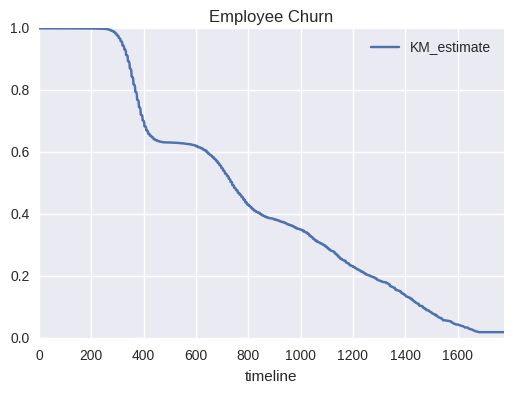

In [301]:
#Create Kaplan-Meier Curve for Overall
from lifelines.estimation import KaplanMeierFitter
kmf = KaplanMeierFitter()

T1 = employee[f]['time2']
C1 = employee[f]['event']

#Plot
kmf.fit(T1, event_observed=C1)
kmf.survival_function_.plot()
plt.title('Employee Churn')

In [307]:
#Create variables for salary
bins = (50000, 150000, 250000, 350000, 410000)
name = ('low', 'med', 'med-hi', 'hi')
employee['salary_cat'] = pd.cut (employee['salary'], bins, labels = name)
employee.head()
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 11 columns):
employee_id    24702 non-null int64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      24702 non-null datetime64[ns]
event          24702 non-null int64
time           24702 non-null timedelta64[ns]
time2          24702 non-null int64
salary_cat     22379 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), int64(5), object(1), timedelta64[ns](1)
memory usage: 1.9+ MB


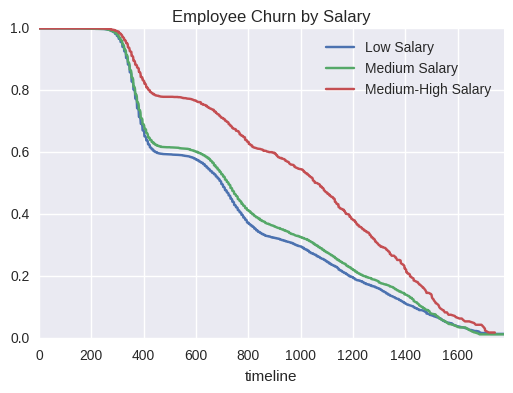

In [308]:
#By Salary 
f1 = employee.salary_cat=='low'
T1 = employee[f1]['time2']
C1= employee[f1]['event']

f2 = employee.salary_cat=='med'
T2 = employee[f2]['time2']
C2= employee[f2]['event']

f3 = employee.salary_cat=='med-hi'
T3 = employee[f3]['time2']
C3= employee[f3]['event']

f4 = employee.salary_cat=='hi'
T4 = employee[f4]['time2']
C4= employee[f4]['event']


ax = plt.subplot(111)

kmf.fit(T1, event_observed=C1, label=['Low Salary'])

kmf.survival_function_.plot(ax=ax)

kmf.fit(T2, event_observed=C2, label=['Medium Salary'])

kmf.survival_function_.plot(ax=ax)

kmf.fit(T3, event_observed=C3, label=['Medium-High Salary'])

kmf.survival_function_.plot(ax=ax)

kmf.fit(T4, event_observed=C4, label=['High Salary'])


plt.title('Employee Churn by Salary')

kmf2 = plt.gcf()

In [313]:
#Run Cox Proportional Hazards to Find Main Factors that Drive Employee Churn
from lifelines import CoxPHFitter

dataset = employee[['seniority','salary', 'time2','event']]
cf = CoxPHFitter()
time = employee['time2']
cf.fit(dataset, 'time2', event_col='event')

cf.print_summary()  # access the results using cf.summary

n=24702, number of events=13510

                coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
seniority  7.348e-02  1.076e+00 1.029e-02  7.144e+00 9.098e-13   5.331e-02   9.364e-02  ***
salary    -1.240e-01  8.833e-01 1.030e-02 -1.205e+01 2.026e-33  -1.442e-01  -1.038e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.529


In [318]:
#Cross-validation splits data into test and train sets and returns out R2 for test set
scores = k_fold_cross_validation(cf, dataset, 'time2', event_col='event', k=5)
print scores
print np.mean(scores)
print np.std(scores)
#R2 = 0.53

[0.52756971981393086, 0.51932786932317299, 0.54724019987032124, 0.52495592684650627, 0.52527053160197124]
0.528872849491
0.00957583761864


### Salary is a significant predictor of employee churn. 
One unit increase in salary is associated with 22% [exp(0.124) = 0.88] decrease in the probability of quitting.